## Imports

In [1]:
from os import listdir
from os.path import join
from datetime import datetime

import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
)

from models import ResNet9
from projected_gradient_descent import PGD
from data_loaders import DeviceDataLoader as DL

### Search for an accelerator

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Model

In [3]:
latest_model_path = join("models", sorted(listdir("models"))[-1])
model_state_dict = torch.load(latest_model_path, weights_only=True)
model = ResNet9(3, 10)
model.load_state_dict(model_state_dict)
model.cuda()
model.eval()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Datasets, Transforms and Data loaders

### Transforms

In [4]:
CHANNELS_MEAN = (0.4914, 0.4822, 0.4465)
CHANNELS_STD = (0.2023, 0.1994, 0.2010)

training_transform = Compose([
    RandomCrop(32, padding=4, padding_mode="constant"),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(CHANNELS_MEAN, CHANNELS_STD, inplace=True),
])
validation_transform = Compose([ToTensor(), Normalize(CHANNELS_MEAN, CHANNELS_STD)])

### Datasets

In [5]:
training_dataset = CIFAR10(root="./datasets/cifar10/", train=True, download=True, transform=training_transform)
validation_dataset = CIFAR10(root="./datasets/cifar10/", train=False, transform=validation_transform)

Files already downloaded and verified


### Datasets loaders

In [6]:
BATCH_SIZE = 400
training_dl = DL(training_dataset, BATCH_SIZE, shuffle=True, num_workers=3, device=device, pin_memory=True)
validation_dl = DL(validation_dataset, BATCH_SIZE * 2, num_workers=3, device=device, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


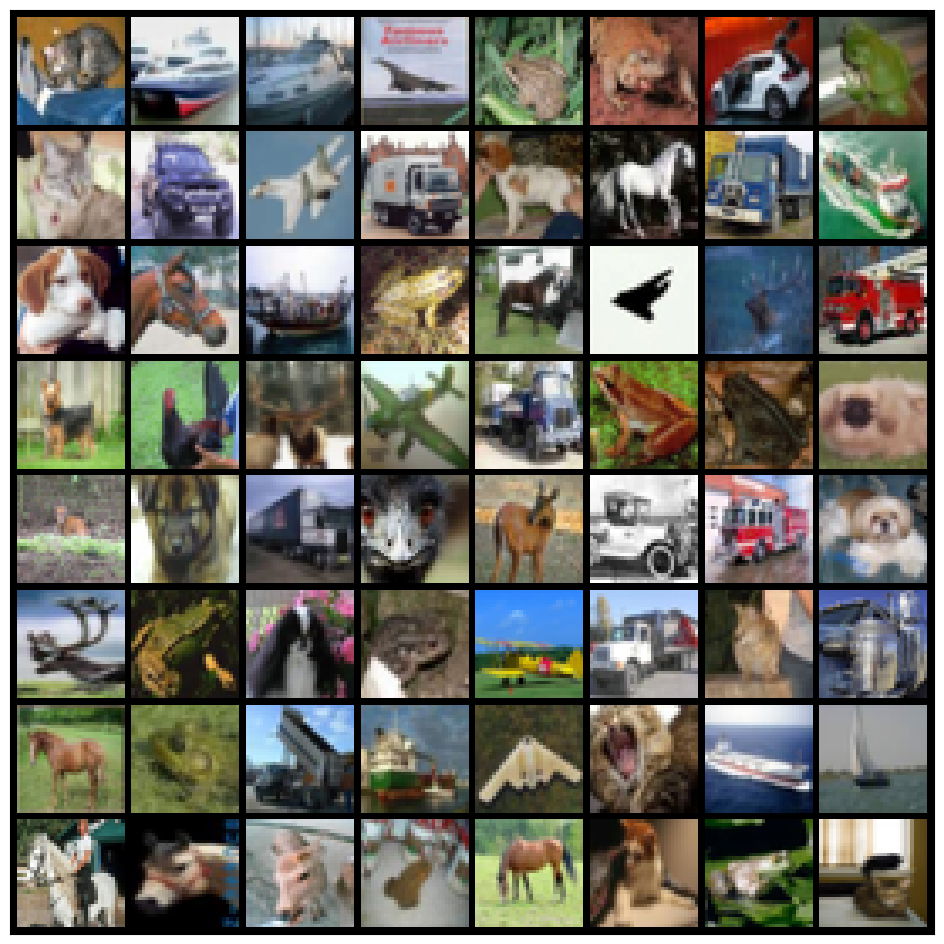

In [7]:
base_imgs, labels = next(iter(validation_dl))
# Ironically, we have to bring the batch back to the CPU
images, labels = base_imgs.cpu(), labels.cpu()
as_tensor = lambda stats: Tensor(stats).view(1, 3, 1, 1)
unormalize_imgs =  lambda imgs: imgs * as_tensor(CHANNELS_STD) + as_tensor(CHANNELS_MEAN)
images = unormalize_imgs(images)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.031529427..1.0317333].


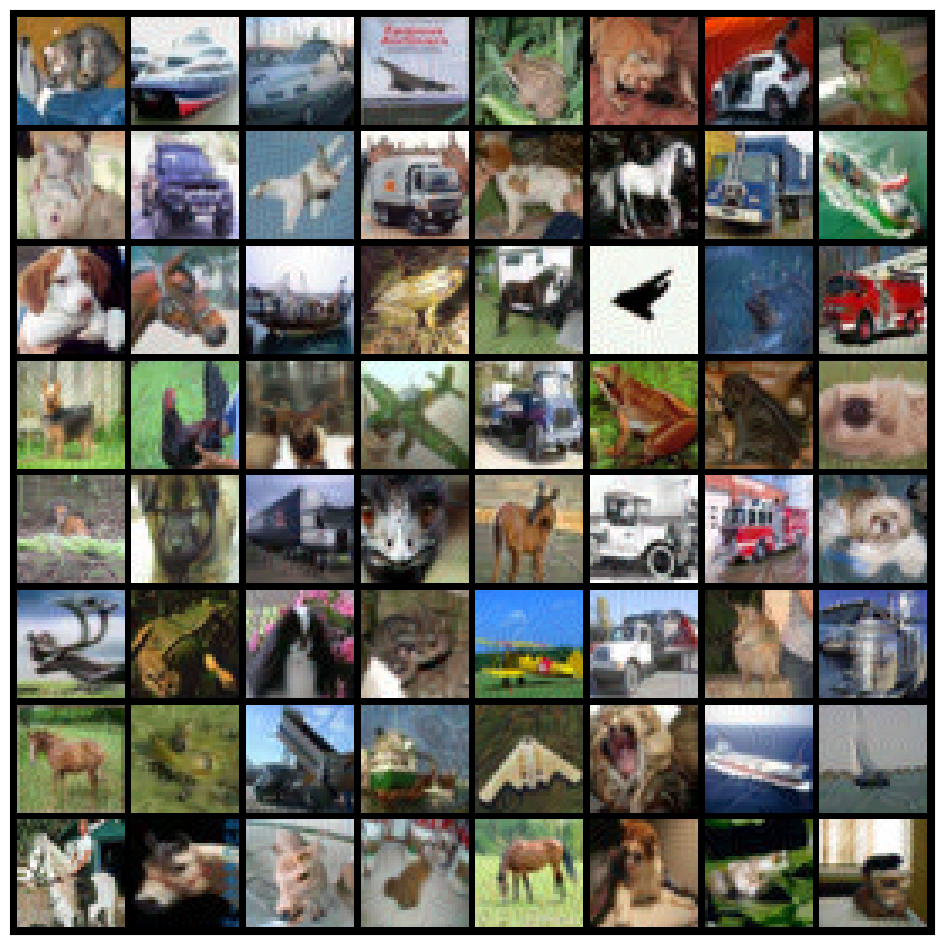

In [11]:
attacker = PGD(10, 4/255, CrossEntropyLoss(), model, 50/255)
atk_imgs = attacker.forward(base_imgs.cuda(), labels.cuda()).cpu()
images = unormalize_imgs(atk_imgs)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))

In [15]:
base_preds = model(base_imgs.cuda()).cpu()
atk_preds = model(atk_imgs.cuda()).cpu()
get_acc = lambda preds, labels: (preds.max(1)[1] == labels).sum() / len(labels)
display(get_acc(base_preds, labels))
display(get_acc(atk_preds, labels))

tensor(0.9162)

tensor(0.)